# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [69]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# load the tweets
documents = []
time_seq = []
weeknum = ''
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        c_twt = json.loads(l)
        
        # remove punctuation and stopwords for this analysis
        c_twt['c_text'] = re.sub('[\.,#?!]', '', c_twt['c_text'])
        words = c_twt['c_text'].split()
        words = [w for w in words if w not in STOPWORDS]
        words = [bytes(w, 'utf-8') for w in words]
        
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        documents.append(words)
        
        if weeknum != c_twt['weeknum']:
            time_seq.append(i)
            weeknum = c_twt['weeknum']
            
time_seq = time_seq[1:]
time_seq.append(len(documents))

acc = 0
for i in range(1, len(time_seq)):
    acc = acc + time_seq[i-1]
    time_seq[i] = time_seq[i] - acc

print(time_seq)

[2, 103272, 56210, 90675, 209467, 41446, 14002, 43918, 188631, 109273, 54007, 25103, 84203, 52225]


In [3]:
class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(documents)

In [4]:
dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                 id2word=corpus.dictionary, initialize_lda=True, rng_seed=0)

In [23]:
topics = model.show_topic(topicid=3, time=11, topn=20)
topics

[(0.051474689170186855, 'prep'),
 (0.040291286758822646, 'rt'),
 (0.020133566699966899, '-'),
 (0.0051307584259089852, 'end'),
 (0.0050477594243479116, 'job'),
 (0.0048487196679626631, 'amp'),
 (0.0045914135661872081, 'malaria'),
 (0.0044333625998869931, 'cook'),
 (0.0043060966761148123, 'boys'),
 (0.0041228311628770907, 'basketball'),
 (0.0037154418845829016, 'new'),
 (0.0034768354564311856, 'girls'),
 (0.0034439157773876756, 'jobs'),
 (0.0031149011452783473, 'school'),
 (0.0028286016826887905, 'act'),
 (0.0027674481427448264, 'disease'),
 (0.0026053680570427679, 'final'),
 (0.0025860613021339092, 'hiv-positive'),
 (0.0024000791211764498, 'time'),
 (0.0023398642622216698, 'bad')]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [77]:
# This cell just gets the week nums (YYYY-WW)
def weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week = week + 1

        if week > 53:
            year =+ 1
            week = 1
    return weeknums

weeknums = weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [52]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability            Word
0     0.035771              rt
1     0.024231         malaria
2     0.013830          africa
3     0.013788               -
4     0.013724         vaccine
5     0.012709      meningitis
6     0.010847         disease
7     0.010829  nothingbutnets
8     0.010822             end
9     0.008797             boy

--- time slice:  1 

   Probability            Word
0     0.035453              rt
1     0.023135         malaria
2     0.015806         vaccine
3     0.014323               -
4     0.013454          africa
5     0.011467         disease
6     0.010724      meningitis
7     0.010260             end
8     0.009747  nothingbutnets
9     0.009656          dengue

--- time slice:  2 

   Probability     Word
0     0.034281       rt
1     0.021182  vaccine
2     0.020693  malaria
3     0.015291        -
4     0.015087   dengue
5     0.012826  disease
6     0.012400   africa
7     0.009047      end
8     0.008719   mexico
9     0.00807

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

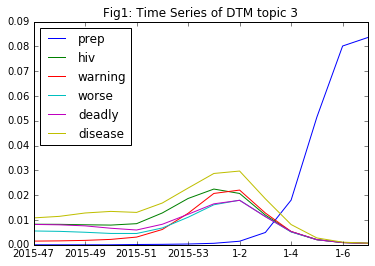

In [79]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hiv', 'warning', 'worse', 'deadly', 'disease']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [53]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=8, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability        Word
0     0.058707         hiv
1     0.055065          rt
2     0.025626        aids
3     0.020794     dentist
4     0.018911      spread
5     0.015861         day
6     0.012742       child
7     0.012596           -
8     0.012422        porn
9     0.011365  scientists

--- time slice:  1 

   Probability        Word
0     0.059894         hiv
1     0.055941          rt
2     0.028147        aids
3     0.017362         day
4     0.015466      spread
5     0.014357           -
6     0.013026  scientists
7     0.013023     dentist
8     0.011849       world
9     0.011209    mosquito

--- time slice:  2 

   Probability        Word
0     0.060507         hiv
1     0.055990          rt
2     0.033136        aids
3     0.020300         day
4     0.018299           -
5     0.016752  scientists
6     0.015781       world
7     0.011342    mosquito
8     0.009790      create
9     0.009771         new

--- time slice:  3 

   Probability        

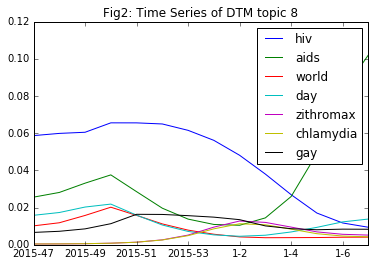

In [76]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=8, time=t_index, topn=1000)
        
    columns = ['hiv', 'aids', 'world', 'day', 'zithromax', 'chlamydia', 'gay']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')